In [1]:
%matplotlib inline

import matplotlib.pyplot as plt
import seaborn as sns

import torch
import numpy as np

import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import seaborn as sns

from selective_gp.models import DeepGPModel
from selective_gp.layers import SVGP

from selective_gp.utils import (
    load_data, get_model, remove_points, fit_layerwise)
from selective_gp.utils.visualization import (
    plot_density, plot_samples, plot_deep_latent)

sns.set(
    font_scale=1.5,
    style="whitegrid",
)
fig_width = 16

In [2]:
def plot_all(model):
    fig, axes = plt.subplots(1, len(model.gps), figsize=(16, 5))
    for i, ax in enumerate(axes, 1):
        ax.set_title(f"Layer {i}")
        ax.margins(x=0)
    plot_deep_latent(model, axes=axes)

    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 5))
    for ax in (ax1, ax2):
        ax.set(xlim=(-5, 25), ylim=(-1, 2))
    ax1.set_title("Posterior samples")
    ax2.set_title("Posterior density")
    plot_samples(model, ax=ax1)
    plot_density(model, ax=ax2)

# Probabilistic selection of inducing points in deep Gaussian processes

In this notebook we demonstrate how the selection of inducing points through variational inference is extended to the more general setting of deep Gaussian processes.

Consider the case of wanting to model a square wave with a sparse Gaussian process with a radial basis function (RBF) kernel (which is generally a bad idea).

In [3]:
dataset = load_data("square_wave", n_observations=200, test_size=0.5)
X, Y = dataset.X_train, dataset.Y_train

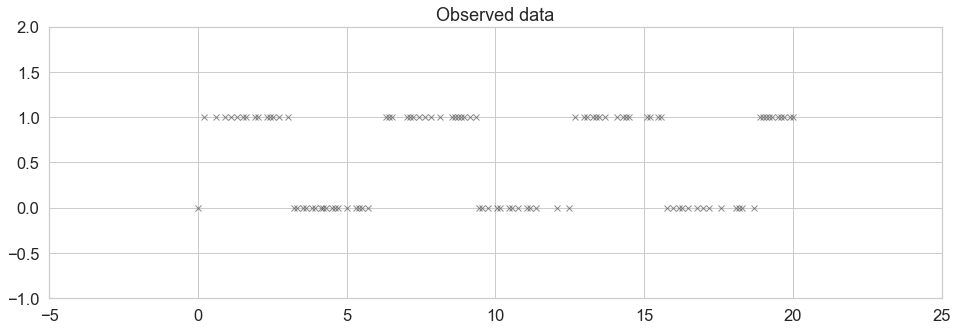

In [4]:
fig, ax = plt.subplots(figsize=(fig_width, 5))
ax.set(title="Observed data", xlim=(-5, 25), ylim=(-1, 2))
ax.plot(X.flatten(), Y.flatten(), "x", color=plt.cm.Greys(0.9, 0.5));

In [5]:
M = 80
model = DeepGPModel(add_input=False)
model.eval()
gp = SVGP(1, 1, n_inducing=M)
model.add_gp(gp)
gp.inducing_inputs = torch.linspace(-5, 25, M)
model.fit(X=X, Y=Y, max_epochs=200)

(<matplotlib.collections.PolyCollection at 0x12c2ccad0>,)

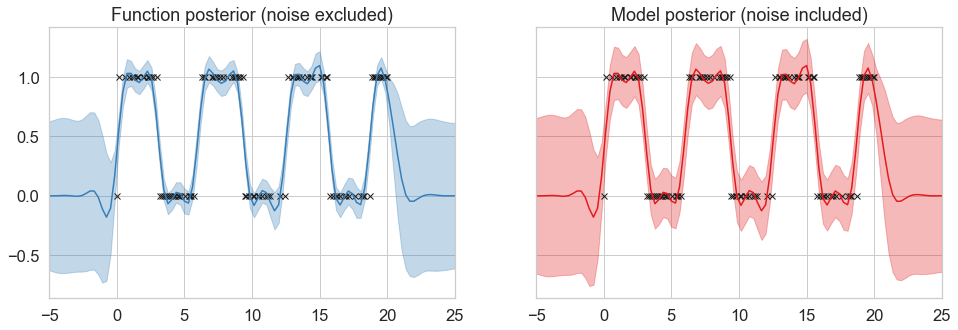

In [6]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 5), sharey=True)
ax1.set_title("Function posterior (noise excluded)")
ax2.set_title("Model posterior (noise included)")
for ax in fig.axes:
    ax.margins(x=0)
    ax.plot(X.flatten(), Y.flatten(), "kx")

cm = plt.cm.Set1
x_in = torch.linspace(-5, 25)
with torch.no_grad():
    f_dist = gp(x_in[:, None])
    y_dist = model.likelihood(f_dist)
f_m, f_s = f_dist.mean, f_dist.stddev
y_m, y_s = y_dist.mean, y_dist.stddev

ax1.plot(x_in, f_m, color=cm(1))
ax1.fill_between(x_in, f_m - f_s, f_m + f_s, color=cm(1, 0.3))
ax2.plot(x_in, y_m, color=cm(0))
ax2.fill_between(x_in, y_m - y_s, y_m + y_s, color=cm(0, 0.3)),

Although not entirely unreasonable, the Gaussian process finds it difficult to handle the discontinuities. This is largely due to a critical assumption, that we have baked into our model through our choice of kernel: that the covariance between any pair of observations is solely determined by their distance (stationarity). In particular, two points in the same, vertical segment (e.g. $x = 0$ and $x = 2$) must have the same covariance as two points with same distance but in different segments (e.g. $x = 2$ and $x = 4$), even though the former pair should obviously be considered more informative about one another. The model is now forced to use a lengthscale that enables "jumping" between segments, but with the result of too much flexibility within segments and high kernel variance and likelihood noise.

One way of circumventing the stationarity assumption is by making multiple compositions of Gaussian processes, thus creating a deep, hierarchical model. That is, the (uncertain) outputs of the first function becomes the (uncertain) inputs to the next function, and so on. Now, two points, that have the same distance in one layer, may not have so in the next, meaning that the stationarity assumption is effectively lifted.

To see how this increases expressiveness, we will add a single layer and re-fit. We initialise the inducing points for the new layer by taking 10 samples from the current model and use the minimum and maximum values as the range limits.

In [7]:
outputs = torch.stack([model.sample(X) for _ in range(10)])
zmin, zmax = outputs.min(), outputs.max()

In [8]:
gp = SVGP(1, 1, n_inducing=M)
model.add_gp(gp)
gp.inducing_inputs = torch.linspace(zmin, zmax, M)
model.fit(X=X, Y=Y, max_epochs=500)

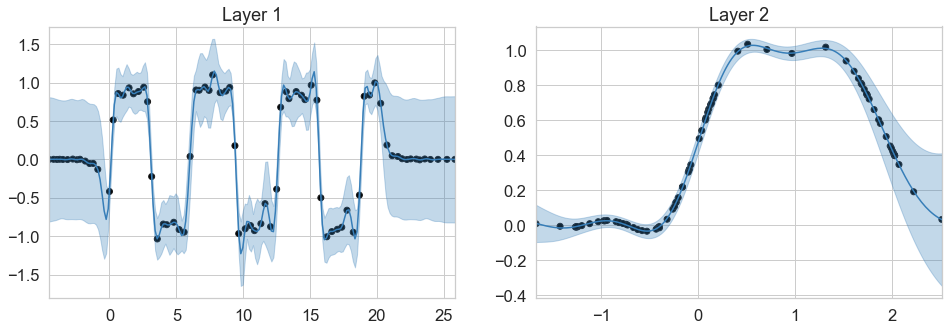

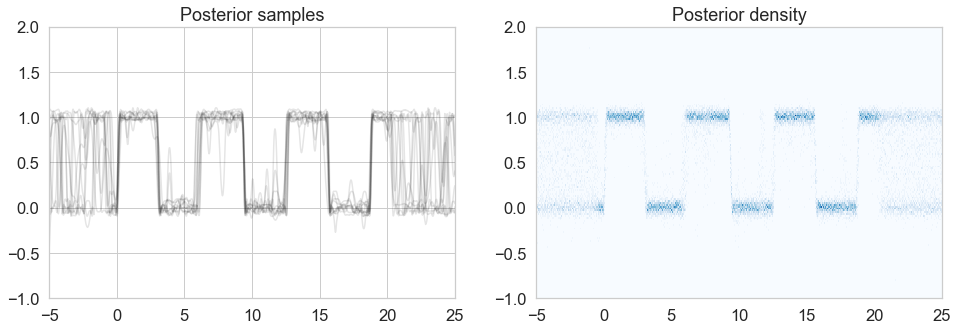

In [9]:
plot_all(model)

The resulting model has learned an approximate step function in the second layer that "pulls apart" 0- and 1-evaluations. Note that the uncertainty outside of the input range $x \in (0, 20)$ now resembles a bi-modal distribution.

We can further refine the estimation by adding another layer.

In [10]:
outputs = torch.stack([model.sample(X) for _ in range(10)])
zmin, zmax = outputs.min(), outputs.max()

In [11]:
gp = SVGP(1, 1, n_inducing=M)
model.add_gp(gp)
gp.inducing_inputs = torch.linspace(zmin, zmax, M)
model.fit(X=X, Y=Y, max_epochs=500)

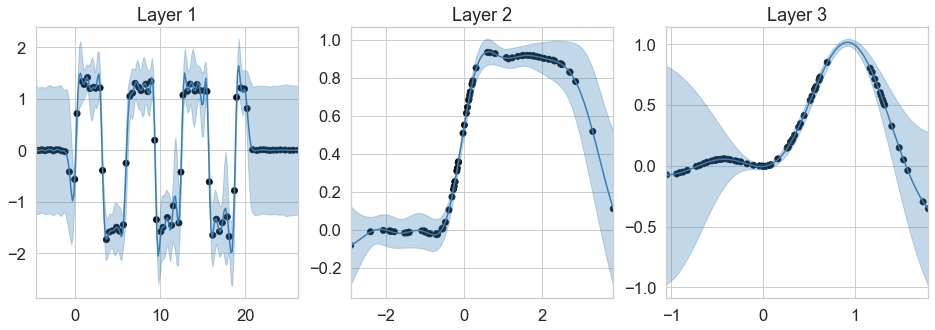

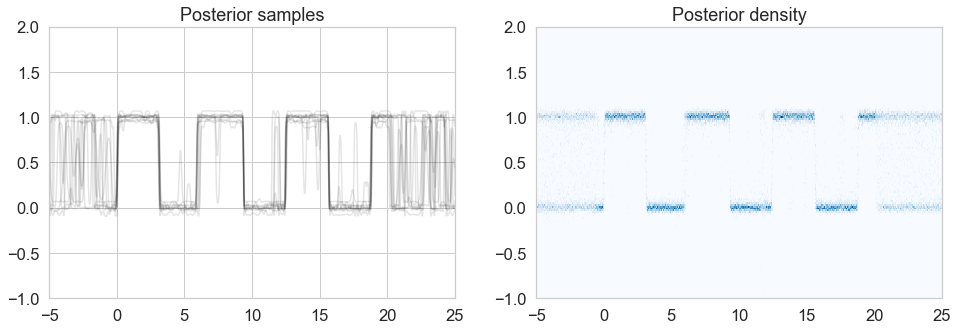

In [12]:
plot_all(model)

At this point, it is informative to consider the complexity of each function in our deep model. While the first function still approximates a square wave and thus needs to cover the entire input range $x = (0, 20)$, the second and third functions are considerably simpler. It may then seem reasonable that quite a few inducing points can be removed from the last two layers without it having severe impact on the predictive capabilities of the model, although it may affect computation time.

To test this hypothesis, we will measure sample time and RSME for the current model, use the variational point processes to prune the layers, and compare.

In [13]:
pre_prune_time = %timeit -o model.sample(dataset.X_test, True)

18.6 ms ± 3.23 ms per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [14]:
samples = torch.stack([model.sample(dataset.X_test) for _ in range(50)])
pre_prune_rmse = (((samples.T - dataset.Y_test)**2).mean()).sqrt()

In [15]:
for gp in model.gps:
    gp.prior_point_process.rate.fill_(0.5)
    gp.variational_point_process.probabilities = 0.2

model.fit_score_function_estimator(
    X=X, Y=Y, learning_rate=0.3, max_epochs=1000,
    n_mcmc_samples=8)

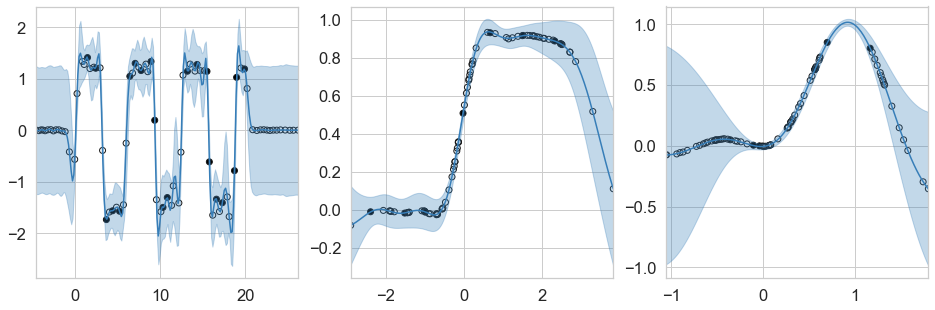

In [16]:
fig, axes = plt.subplots(1, 3, figsize=(fig_width, 5))
for ax in axes:
    ax.margins(x=0)
plot_deep_latent(model, axes=axes)

The filling of each pseudo-point in the above figure is the latent probability of inclusion as inferred by the variational points processes. Note that more points are deemed redundant in the 2nd and 3rd layer.

We remove those points by sampling from the point processes, and then re-fit the pruned model.

In [17]:
for gp in model.gps:
    remove_points(gp)

for i, gp in enumerate(model.gps, 1):
    print(f"Number of pseudo-points in layer {i}: {gp.n_inducing}")

model.fit(X=X, Y=Y, max_epochs=500, hp_learning_rate=0.005,
          var_learning_rate=0.01)

Number of pseudo-points in layer 1: 21
Number of pseudo-points in layer 2: 9
Number of pseudo-points in layer 3: 8


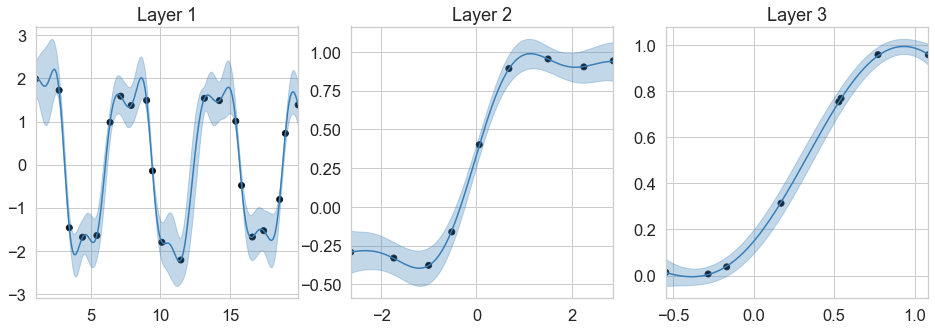

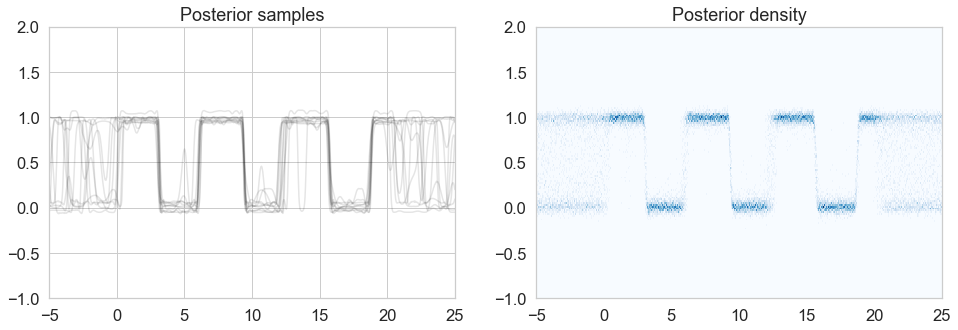

In [18]:
plot_all(model)

Notice that there does not seem to be much, if any, detoriation in the predictive capabilities. Comparing to the pre-pruned model:

In [19]:
post_prune_time = %timeit -o model.sample(dataset.X_test, True)

samples = torch.stack([model.sample(dataset.X_test) for _ in range(50)])
post_prune_rmse = (((samples.T - dataset.Y_test)**2).mean()).sqrt()

25.3 ms ± 5.41 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [20]:
print(f"Pre-prune RMSE:  {pre_prune_rmse:.2e}\n"
      f"Pre-prune time:  {pre_prune_time}\n\n"
      f"Post-prune RMSE: {post_prune_rmse:.2e}\n"
      f"Post-prune time: {post_prune_time}")

Pre-prune RMSE:  2.73e-01
Pre-prune time:  18.6 ms ± 3.23 ms per loop (mean ± std. dev. of 7 runs, 100 loops each)

Post-prune RMSE: 2.78e-01
Post-prune time: 25.3 ms ± 5.41 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)
